In [324]:
import numpy as np
import scipy.stats
import random
from statistics import median
import sklearn.linear_model
from scipy.stats import pearsonr

In [325]:
filename = "generated_data"
with open(filename) as f:
    rowID = None
    while rowID != "Affymetrix":
        line = f.readline().rstrip().split()
        rowID = line[0]
        if rowID == "IDs":
            columns = range(len(line))[1:]
            ids = line[1:]
        if rowID == "ModalAllele":
            mal = [int(i) for i in line[1:]]
        if rowID == "ActualMAL":
            actual_mal = [int(i) for i in line[1:]]
        if rowID == "Affymetrix":
            affected_genes = [i for i in line[1:]]
            affected_genes = [int(i.split('id')[1]) for i in affected_genes]
            data = np.loadtxt(f, delimiter="\t", usecols=columns)
data = data.T

In [326]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[..., just_indices]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[1]):
        #print(data[i, ...].shape)
        y = data[..., i].reshape(-1).flatten().tolist()
        #print(y)
        #print(allele.reshape(-1).flatten().tolist()[0])
        gene_r, _ = pearsonr(allele.reshape(-1).flatten().tolist()[0], y)
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[0]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[training_indices, :], data[test_indices, :]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

def non_zero_indices(l):
    relative = median(l)
    return [i for i, a in enumerate(l) if abs(a) > relative * 10**(-5)]

In [327]:
size, _ = data.shape

In [328]:
import math

In [329]:
results = []
for j in range(2):
    for i in range(1, 200):
        training_i, testing_i = choose_training_indicies(data, math.ceil(size * 0.66))
        training_fold, testing_fold = split_data(data, training_i, testing_i)
        repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
        repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)

        top_genes = order_indicies(repeat_length_training, training_fold)[:i]
        training_set = choose_top_genes(top_genes, training_fold)
        testing_set = choose_top_genes(top_genes, testing_fold)

        shitty_linear_regression = sklearn.linear_model.LinearRegression()
        shitty_linear_regression.fit(training_set, repeat_length_training)
        score = shitty_linear_regression.score(testing_set, repeat_length_testing)
        results.append((i, score))

In [330]:
gene_no = [i[0] for i in results]

In [331]:
performance = [i[1] for i in results]

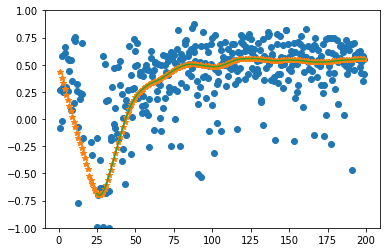

In [332]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = gene_no
y = performance

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.2)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = np.linspace(25, max(x), 1000)

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.ylim([-1, 1])
discover_max = [(i, j) for i, j in zip(ynew, xnew) if i < 1]

In [333]:
optimal_param = int(max(discover_max)[1])

In [334]:
optimal_param

126

In [335]:
n = 100

In [336]:
mal_results = []
ground_truth = []
for i in range(n):
    training_i, testing_i = choose_training_indicies(data, math.ceil(size * 0.66))
    training_fold, testing_fold = split_data(data, training_i, testing_i)
    repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
    repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)

    top_genes = order_indicies(repeat_length_training, training_fold)[:optimal_param]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    shitty_linear_regression = sklearn.linear_model.LinearRegression()
    shitty_linear_regression.fit(training_set, repeat_length_training)
    scores = shitty_linear_regression.predict(testing_set)
    #print(scores.reshape(-1))
    mal_results.extend(scores.reshape(-1))
    ground_truth.extend(repeat_length_testing.reshape(-1).tolist()[0])

In [337]:
sklearn.metrics.r2_score(mal_results, ground_truth)

0.45481031398532223

In [338]:
actualmal_results = []
actualmal_ground_truth = []
for i in range(n):
    training_i, testing_i = choose_training_indicies(data, math.ceil(size * 0.66))
    training_fold, testing_fold = split_data(data, training_i, testing_i)
    repeat_length_training = np.matrix([actual_mal[i] for i in training_i]).reshape(-1, 1)
    repeat_length_testing = np.matrix([actual_mal[i] for i in testing_i]).reshape(-1, 1)

    top_genes = order_indicies(repeat_length_training, training_fold)[:optimal_param]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    shitty_linear_regression = sklearn.linear_model.LinearRegression()
    shitty_linear_regression.fit(training_set, repeat_length_training)
    scores = shitty_linear_regression.predict(testing_set)
    #print(scores.reshape(-1))
    actualmal_results.extend(scores.reshape(-1))
    actualmal_ground_truth.extend(repeat_length_testing.reshape(-1).tolist()[0])

In [339]:
sklearn.metrics.r2_score(actualmal_results, actualmal_ground_truth)

0.9587167754313823

(0, 1)

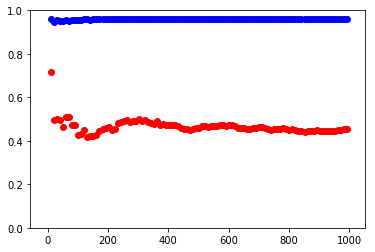

In [340]:
iis = []
rs = []
actual_mal_rs = []
for i in range(2, len(mal_results), 10):
    r = sklearn.metrics.r2_score(mal_results[:i], ground_truth[:i])
    actual_mal_r = sklearn.metrics.r2_score(actualmal_results[:i], actualmal_ground_truth[:i])
    iis.append(i)
    rs.append(r)
    actual_mal_rs.append(actual_mal_r)

plt.scatter(iis, rs, color="r")
plt.scatter(iis, actual_mal_rs, color="b")
plt.ylim([0, 1])

In [341]:
len(set([i[1] for i in top_genes]).intersection(affected_genes))

126

# Compare with Shitasso

In [342]:
#for alpha in [10**i]
training_i, testing_i = choose_training_indicies(data, math.ceil(size * 0.8))
training_fold, testing_fold = split_data(data, training_i, testing_i)
repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)
lasso = sklearn.linear_model.Lasso(alpha=0.005, max_iter=10000)
lasso.fit(training_fold, repeat_length_training)
lasso.score(testing_fold, repeat_length_testing)

-0.8679426229610043

In [343]:
learnt_coeffs = non_zero_indices(lasso.coef_)

In [344]:
len(learnt_coeffs)

418

In [345]:
len(affected_genes)

200

In [346]:
len(set(affected_genes).intersection(learnt_coeffs))

35

# ISEs

In [347]:
top_genes_all = [i[1] for i in order_indicies(repeat_length_training, training_fold)[:optimal_param]]

In [348]:
filtered_data = data[..., top_genes_all]
i = 10
errors = []

for i in range(filtered_data.shape[1]):
    for_ise.fit(mal_var, filtered_data[..., i].reshape(-1, 1))
    for_ise.predict(mal_var)
    error = for_ise.predict(mal_var) - filtered_data[..., i].reshape(-1, 1)
    errors.append(error)

errors = np.hstack(errors)

ISEs = []
for i in range(errors.shape[0]):
    ISEs.append(np.mean(errors[i, ...]))


corrected_data = data + np.vstack([ISEs for i in range(data.shape[1])]).T

In [349]:
sklearn.metrics.r2_score(corrected_data, data)

0.9948148362327219

In [350]:
mal_ISE_results = []
ground_ISE_truth = []
for i in range(n):
    training_i, testing_i = choose_training_indicies(corrected_data, math.ceil(size * 0.66))
    training_fold, testing_fold = split_data(data, training_i, testing_i)
    repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
    repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)

    top_genes = order_indicies(repeat_length_training, training_fold)[:optimal_param]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    shitty_linear_regression = sklearn.linear_model.LinearRegression()
    shitty_linear_regression.fit(training_set, repeat_length_training)
    scores = shitty_linear_regression.predict(testing_set)
    #print(scores.reshape(-1))
    mal_ISE_results.extend(scores.reshape(-1))
    ground_ISE_truth.extend(repeat_length_testing.reshape(-1).tolist()[0])

In [351]:
sklearn.metrics.r2_score(corrected_data, data)

0.9948148362327219

In [352]:
len(ISEs)

30

In [353]:
sklearn.metrics.r2_score(mal_ISE_results, ground_ISE_truth)

0.47210169846141203

(0, 1)

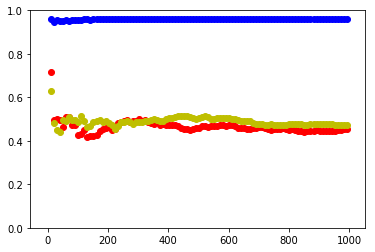

In [354]:
iis = []
rs = []
actual_mal_rs = []
ISE_mal_rs = []
for i in range(2, len(mal_results), 10):
    r = sklearn.metrics.r2_score(mal_results[:i], ground_truth[:i])
    actual_mal_r = sklearn.metrics.r2_score(actualmal_results[:i], actualmal_ground_truth[:i])
    ISE_mal_r = sklearn.metrics.r2_score(mal_ISE_results[:i], ground_ISE_truth[:i])
    iis.append(i)
    rs.append(r)
    actual_mal_rs.append(actual_mal_r)
    ISE_mal_rs.append(ISE_mal_r)

plt.scatter(iis, rs, color="r")
plt.scatter(iis, actual_mal_rs, color="b")
plt.scatter(iis, ISE_mal_rs, color="y")
plt.ylim([0, 1])

# Scratchpad

In [167]:
training_fold.shape

(24, 2000)

In [ ]:
testing_fold.shape

In [ ]:
repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)

In [ ]:
repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)

In [ ]:
repeat_length_testing.shape

In [ ]:
#training_set = choose_top_genes(top_genes, training_fold)
#testing_set = choose_top_genes(top_genes, testing_fold)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#training_fold[..., 8879]

In [ ]:
#len(training_fold[..., 8879].reshape(-1).tolist())

In [245]:
#len()

In [246]:
#plt.scatter(repeat_length_training.reshape(-1).tolist()[0], training_fold[..., 8879].reshape(-1).tolist())

In [247]:
#plt.scatter(repeat_length_testing.reshape(-1).tolist()[0], testing_fold[..., 8879].reshape(-1).tolist())

In [248]:
training_fold.shape

(24, 2000)

In [249]:
repeat_length_training.shape

(24, 1)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

0.3598934530657103

76

In [261]:
lasso.predict(training_fold)

array([ 881.99621584,  646.99213975,  565.01442858,  437.01267989,
        -86.95756412,  859.00103575, 1096.99963579,  837.9909115 ,
        663.98545323,   64.99654113,   43.99715824,  376.99495719,
        177.01231577,  838.00394629,  709.95678815,  283.03162546,
        351.98786501, 1003.97060892,  825.00847619,  414.0013541 ,
        155.00747679,  870.99558116,  606.01667373,  395.98369566])

In [254]:


    
results = list(lasso.predict(testing_set.transpose()))
    
results = [filter_extremes(i, min(repeat_length_training), max(repeat_length_training)) for i in results]

repeat_length_testing, results

NameError: name 'top_genes' is not defined

In [255]:
model = sklearn.linear_model.LassoCV(alphas=[10**(i) for i in range(-10, 0)])

In [45]:
model.fit(data, mal)

/home/picrin/programming/clinical_applications/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/picrin/programming/clinical_applications/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [47]:
model.alpha_

0.01

In [55]:
for i in range(-5, 0):
    m = sklearn.linear_model.LassoCV(alphas=[10**(i)], max_iter=3000)
    m.fit(data, mal)
    print(i, m.score(data, mal))

-5 0.849871069239366
-4 0.8498711365149089
-3 0.8498716377690497
-2 0.8498811591544839


/home/picrin/programming/clinical_applications/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-1 0.8499600165895532


/home/picrin/programming/clinical_applications/venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [48]:
data = np.matrix(data)

In [49]:
model.predict(data[0, ...])

array([-1.01676417])

In [56]:
model.score(data, mal)

0.9999999981896337

In [ ]:
model.sco

In [ ]:
model = sklearn.linear_model.Lasso()